# 9. Overview of time-domain EEG analyses

In [13]:
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits import mplot3d # need this for 3d plots

import mne
from mne.externals.pymatreader import read_mat

### Figure 9.1a

In [3]:
# load data using MNE
data_in = read_mat('sampleEEGdata.mat')
EEG = data_in['EEG']

In [4]:
#get all the data we need from the eeg file. Working with .mat files like this is not ideal, as you can clearly see below. 
#A better way to access this data would be to re-save the sampleEEGdata.mat file as v-7.3 in matlab, or convert it to hdf5,
#then open it in python using h5py or pytables. Since I'd rather not mess with the batteries-included-ness of this book, 
#I'll keep the data as-is and extract what we'll need. 
data = scipy.io.loadmat('sampleEEGdata')

eeg_data = data["EEG"][0,0]["data"]
eeg_pts = data["EEG"][0,0]["pnts"][0,0] #number of points in EEG data
eeg_times = data["EEG"][0,0]["times"][0]
eeg_rate = float(data["EEG"][0,0]["srate"][0]) #make float for division purposes later
eeg_trials = data["EEG"][0,0]["trials"][0,0]
eeg_epoch=data["EEG"][0,0]["epoch"][0]

which_channel_to_plot = 'FCz' #specify label of channel to plot
eeg_chan_locs_labels=data["EEG"][0,0]["chanlocs"][0]["labels"]
channel_index = (eeg_chan_locs_labels  == which_channel_to_plot) #specify index (channel number) of label

<Figure size 720x432 with 0 Axes>

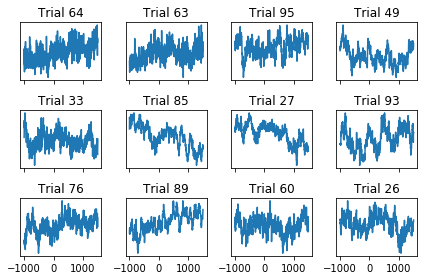

In [5]:
x_axis_limit = (-200, 1000) #in milliseconds

num_trials2plot = 12

plt.figure(figsize=(10, 6))
    
# pick a random trials using random.choice (from numpy.random)
random_trial_to_plot = np.random.choice(np.arange(eeg_trials), num_trials2plot)

# figure out how many subplots we need
n_rows = np.ceil(num_trials2plot/np.ceil(np.sqrt(num_trials2plot))).astype(int)
n_cols = np.ceil(np.sqrt(num_trials2plot)).astype(int)
fig, ax = plt.subplots(n_rows, n_cols, sharex='all')

for ii in range(num_trials2plot):
    idx = np.unravel_index(ii, (n_rows, n_cols))

    #plot trial and specify x-axis and title
    ax[idx].plot(eeg_times, np.squeeze(eeg_data[channel_index,:,random_trial_to_plot[ii] - 1]))
    ax[idx].set(title=f"Trial {random_trial_to_plot[ii]}", yticks=[])

fig.tight_layout()

### Figure 9.1b

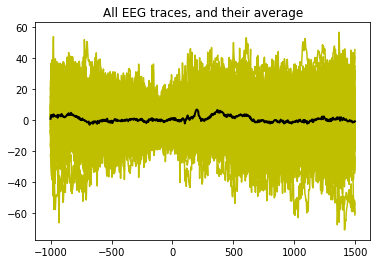

In [6]:
#plot all trials
plt.plot(eeg_times,np.squeeze(eeg_data[channel_index,:,:]),'y')

#plot the event-related potential (ERP), i.e. the average time-domain signal
plt.plot(eeg_times,np.squeeze(np.mean(eeg_data[channel_index,:,:],axis=2)),'k',linewidth=2)
_=plt.title("All EEG traces, and their average")

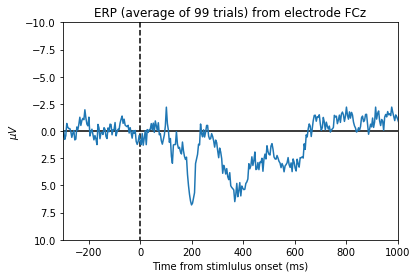

In [7]:
#now plot only the ERP
plt.plot(eeg_times,np.squeeze(np.mean(eeg_data[channel_index,:,:],axis=2))) #axis=2 specifies which axis to compute the mean along
plt.vlines(0,-10,10,linestyles='dashed')
plt.hlines(0,-1000,1500)

plt.axis([-300,1000,-10,10])
plt.xlabel("Time from stimlulus onset (ms)")
plt.ylabel(r'$ \mu V $') #latex interpreter looks for dollar signs
plt.title("ERP (average of " + str(eeg_trials) + " trials) from electrode " + eeg_chan_locs_labels[channel_index][0][0])
plt.gca().invert_yaxis() #EEG convention to flip y axis

### Figure 9.2
To my knowledge, Python (specifically, scipy) does not have a function that is completely analgous to MATLAB's firls(). A very close approximation that I will use instead is an n-th order Butterworth bandpass filter. 

#TODO

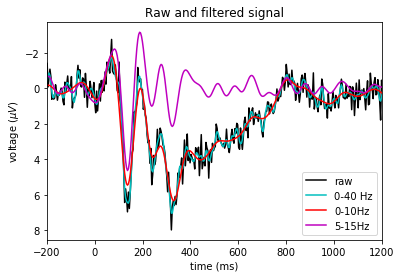

In [8]:
import scipy.signal as sig

chan2plot = "P7"

channel_index = eeg_chan_locs_labels  == chan2plot #specify index (channel number) of label

erp = np.squeeze(np.mean(eeg_data[channel_index,:,:],axis=2))

nyquist = eeg_rate/2.
transition_width = 0.15

#low-pass filter data
#we'll look at filtering in detail in chapter 14

#filter form 0-40
filter_high = 40 #Hz; high cut off
b, a = sig.butter(5, np.array([filter_high*(1+transition_width)])/nyquist,btype="lowpass")
erp_0to40 = sig.filtfilt(b, a, erp, padlen=150) #use filfilt (filters forwards and backwards to eliminate phase shift)

#next, filter from 0-10
filter_high = 10 #Hz
b, a = sig.butter(5, np.array([filter_high*(1+transition_width)])/nyquist,btype="lowpass")
erp_0to10 = sig.filtfilt(b, a, erp, padlen=150)


#next, filter from 5-15
filter_low = 5 # Hz

filter_high = 15 # Hz
b, a = sig.butter(5, np.array([filter_low*(1-transition_width), filter_high*(1+transition_width)])/nyquist,btype="bandpass")
erp_5to15 = sig.filtfilt(b, a, erp, padlen=150)

plt.figure()
plt.plot(eeg_times,erp,'k')
plt.plot(eeg_times,erp_0to40,'c')
plt.plot(eeg_times,erp_0to10,'r')
plt.plot(eeg_times,erp_5to15,'m')

plt.xlim([-200,1200])
plt.gca().invert_yaxis()
plt.xlabel("time (ms)")
plt.ylabel("voltage " + r"$(\mu V)$")
plt.title("Raw and filtered signal")
_=plt.legend(['raw','0-40 Hz','0-10Hz','5-15Hz']) 


### Figure 9.3

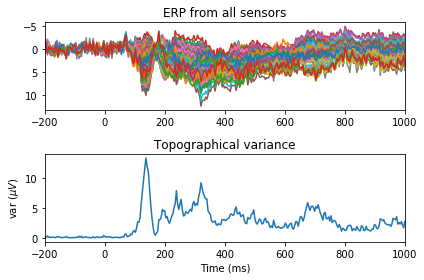

In [9]:
plt.figure()

plt.subplot(211)
plt.plot(eeg_times,np.squeeze(eeg_data.mean(axis=2)).T)
plt.xlim([-200, 1000])
plt.gca().invert_yaxis() #flip for EEG conventions
plt.title("ERP from all sensors")

#topographical variance plot

plt.subplot(212)
plt.plot(eeg_times,np.squeeze(eeg_data.mean(axis=2).var(axis=0)))
plt.xlim([-200,1000])
plt.xlabel("Time (ms)")
plt.ylabel("var "+r'$ (\mu V) $')
plt.title("Topographical variance")
plt.tight_layout()

### Figures 9.4

In [10]:
# create mne Evoked object

# create channel montage 
chan_labels = EEG['chanlocs']['labels']
coords = np.vstack([EEG['chanlocs']['Y'],EEG['chanlocs']['X'],EEG['chanlocs']['Z']]).T
montage = mne.channels.make_dig_montage(ch_pos=dict(zip(chan_labels, coords)), coord_frame='head')

# create MNE Info and Evoked object
info = mne.create_info(chan_labels, EEG['srate'] ,ch_types='eeg')
evoked = mne.EvokedArray(EEG['data'].mean(axis=2), info, tmin=EEG['xmin'])
evoked.set_montage(montage);

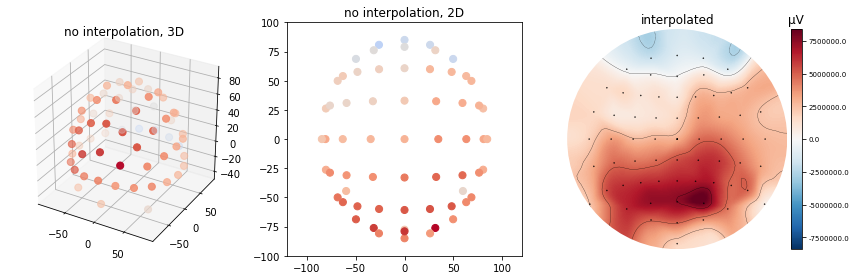

In [12]:
# topoplot with colored dots vs. interpolated surface

# average voltage over trials for a given timepoint
TOI = 300 # ms
c = EEG['data'].mean(axis=2)[:, np.argmin(abs(EEG['times'] - TOI))]

# create figure
fig = plt.figure(figsize=(12,4), tight_layout=True)

# plot topomap without interpolation, 3D
clim = np.max(np.abs(c))
ax_1 = fig.add_subplot(131, projection='3d')
ax_1.scatter(EEG['chanlocs']['Y'], EEG['chanlocs']['X'], 
             EEG['chanlocs']['Z'], s=50, c=c, 
             cmap='coolwarm', vmin=-clim, vmax=clim)
ax_1.set(title='no interpolation, 3D')

# plot topomap without interpolation
ax_2 = fig.add_subplot(132)
ax_2.scatter(EEG['chanlocs']['Y'], EEG['chanlocs']['X'], s=50, c=c, 
             cmap='coolwarm', vmin=-clim, vmax=clim)
ax_2.set(title='no interpolation, 2D')
ax_2.set_xlim([-120,120])
ax_2.set_ylim([-100,100])

# plot interpolated data
# make colorbar axis
ax_3 = fig.add_subplot(133)
divider = make_axes_locatable(ax_3)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax_3.set(title='interpolated')
evoked.plot_topomap(times=TOI/1000, axes=(ax_3, cax), time_format='');


### Figures 9.5

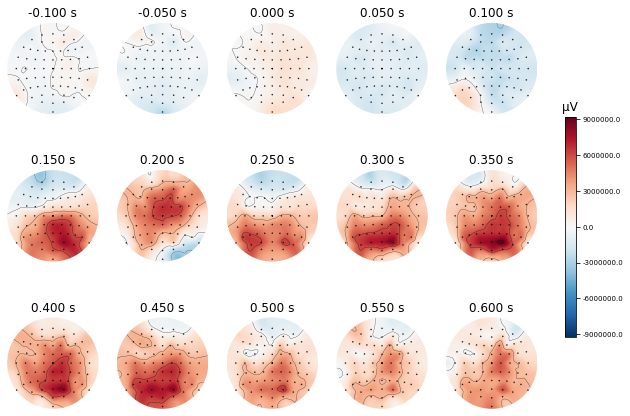

In [14]:
# plot topomap, interpolated surface, 50 ms intervals
evoked.plot_topomap(times=np.linspace(-100,600,15)/1000, nrows=3);

### Figure 9.6

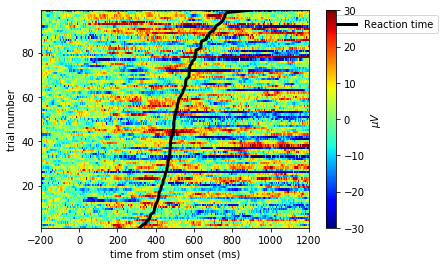

In [15]:
use_rts = True #or false

#get RTs from each trial to use for sorting trials. In this experiment,
#the RT was always the first event after the stimulus (the time=0 event).
#Normally, you should build in exceptions in case there was no response or
#another event occured between the stimulus and response. This was already
#done for the current dataset. 

rts = np.zeros(len(eeg_epoch))

for ei in range(len(eeg_epoch)):
    
    #first, find the index at which time = 0 event occurs
    time0event =  eeg_epoch[ei]["eventlatency"][0]  == 0 #bool array of where time=0 occurs
    time0event = np.where(time0event == time0event.max())[0][0] # find the index of the True value in this array
    
    rts[ei] = eeg_epoch[ei]["eventlatency"][0][time0event+1]
    

if use_rts:
    rts_idx=np.argsort(rts)
else:
    rts_idx = np.argsort(np.squeeze(eeg_data[46,333,:]))
    

#plot the trials for one channel, in (un)sorted order
plt.imshow(np.squeeze(eeg_data[46,:,rts_idx]),
           extent=[eeg_times[0], eeg_times[-1], 1, eeg_trials],
           aspect="auto",
           cmap=plt.get_cmap("jet"),
           origin="lower",
           interpolation="none")


plt.xlabel("time from stim onset (ms)")
plt.ylabel("trial number")
plt.clim([-30,30])
plt.colorbar(label=r"$\mu V$")
plt.axis([-200,1200,1,99])
plt.grid(False)

if use_rts:
    rtplot=plt.plot(rts[rts_idx],np.arange(1,eeg_trials+1),'k',linewidth=3, label= "Reaction time")
    plt.legend(bbox_to_anchor=[1.5,1]) #put the legend outside of the image